In [1]:
import torch
import torchvision as tv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import time
import os
from warnings import filterwarnings 
filterwarnings('ignore')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,), (0.5,))
])

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
val_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
b_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=b_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_data, batch_size=b_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
images = []
labels = []
for i in range(1000):
    image, label = train_data[i]
    if label not in labels:
        labels.append(label)
        images.append(image)
print('Image size:', images[0].shape[0], images[0].shape[1], images[0].shape[2])

Image size: 3 32 32


In [4]:
def get_bar(data):
    labels, counts = torch.unique(torch.Tensor(data.targets), return_counts=True)
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.bar(labels.numpy(), counts.numpy())

    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    ax.set_title(f'Label Distribution in CIFAR10 Dataset')

    plt.show()

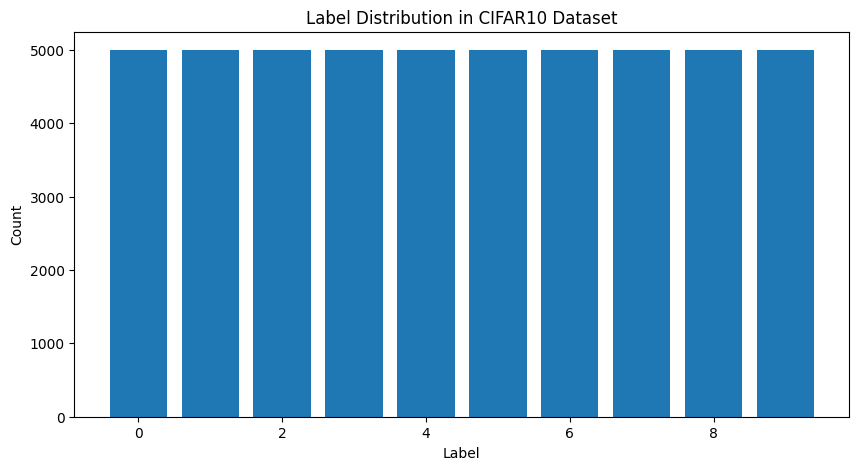

In [5]:
get_bar(train_data)

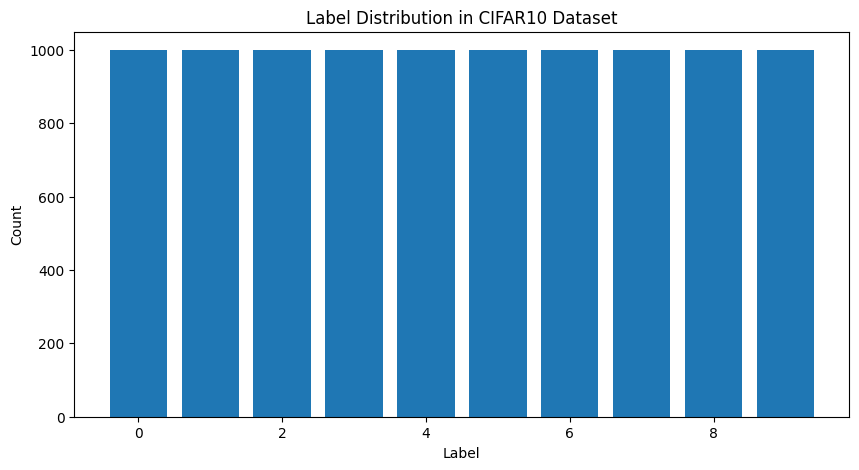

In [6]:
get_bar(val_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

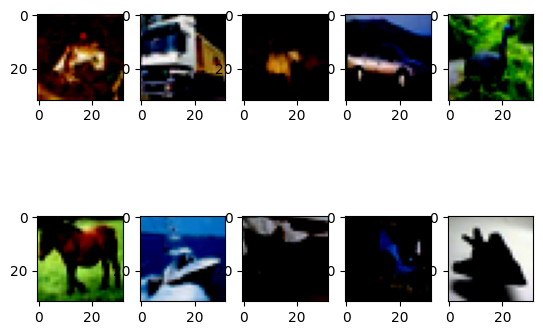

In [7]:
images = []
labels = []
for i in range(100):
    image, label = train_data[i]
    if label not in labels:
        labels.append(label)
        images.append(image)
        
fig, axes = plt.subplots(nrows=2, ncols=5)
for i, img in enumerate(images):
    row = i // 5
    col = i % 5
    axes[row][col].imshow(img.permute(1,2,0))
plt.show()

In [8]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3072, 1024),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(256),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(128),
    torch.nn.Dropout(p=0.3),
    torch.nn.Linear(128, 10)
    
)

In [9]:
loss = torch.nn.CrossEntropyLoss()
training = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 10

In [10]:
def trainer(model, loss, training, num_epochs):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    for epoch in range(num_epochs):
        train_iters, train_passed  = 0, 0
        train_loss, train_acc = 0., 0.
        start=time.time()
        
        model.train()
        
        for X, y in train_loader:
            
            training.zero_grad()
            y_pred = model(X)
            l = loss(y_pred, y)
            l.backward()
            training.step()
            train_loss += l.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item()
            train_iters += 1
            train_passed += len(X)
        
        test_iters, test_passed  = 0, 0
        test_loss, test_acc = 0., 0.
        model.eval()
        for X, y in test_loader:
            y_pred = model(X)
            l = loss(y_pred, y)
            test_loss += l.item()
            test_acc += (y_pred.argmax(dim=1) == y).sum().item()
            test_iters += 1
            test_passed += len(X)
            
        train_losses.append(train_loss / train_iters) 
        test_losses.append(test_loss / test_iters)
        train_accs.append(train_acc / train_passed)
        test_accs.append(test_acc / test_passed)
            
        print("Epoch: {}\n Time taken: {:.2f}\n train_loss: {}, train_acc: {} \n test_loss: {}, test_acc: {}\n".format(
            epoch+1, time.time() - start, train_loss / train_iters, train_acc / train_passed,
            test_loss / test_iters, test_acc / test_passed)
        )
    fig, axs = plt.subplots(nrows=1, ncols=2)    
    eps = range(1, num_epochs+1)
    axs[0].plot(eps, train_losses, label='Train Loss')
    axs[0].plot(eps, test_losses, label='Test Loss')
    axs[1].plot(eps, train_accs, label='Train acc')
    axs[1].plot(eps, test_accs, label='Test acc')
    axs[0].set_title('Losses')
    axs[1].set_title('Accuracy')
    axs[0].legend(loc='upper left')
    axs[1].legend(loc='upper left')
    plt.show()

Epoch: 1
 Time taken: 23.75
 train_loss: 1.726439503757545, train_acc: 0.37866 
 test_loss: 1.508262506014184, test_acc: 0.4568

Epoch: 2
 Time taken: 24.31
 train_loss: 1.5171924896557312, train_acc: 0.45754 
 test_loss: 1.398829149294503, test_acc: 0.4979

Epoch: 3
 Time taken: 24.31
 train_loss: 1.4227488824473622, train_acc: 0.4919 
 test_loss: 1.3378114504150198, test_acc: 0.5228

Epoch: 4
 Time taken: 24.45
 train_loss: 1.3537659776180297, train_acc: 0.51672 
 test_loss: 1.3300770490984373, test_acc: 0.5253

Epoch: 5
 Time taken: 24.49
 train_loss: 1.3008148252506695, train_acc: 0.53494 
 test_loss: 1.2969204338291023, test_acc: 0.5369

Epoch: 6
 Time taken: 24.59
 train_loss: 1.2496376141257908, train_acc: 0.55634 
 test_loss: 1.2772895739048342, test_acc: 0.5403

Epoch: 7
 Time taken: 24.63
 train_loss: 1.2086184335791545, train_acc: 0.57034 
 test_loss: 1.2841127605377873, test_acc: 0.5396

Epoch: 8
 Time taken: 24.89
 train_loss: 1.1664001934058832, train_acc: 0.5854 
 test_l

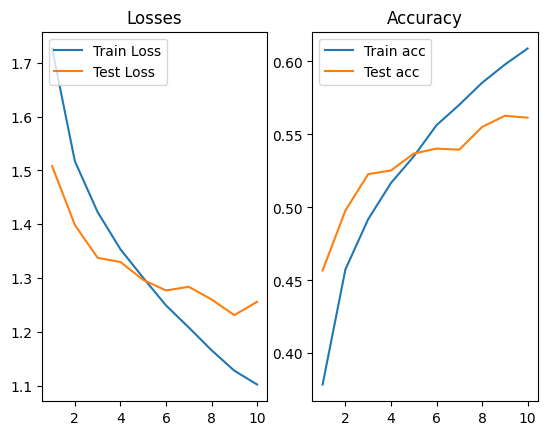

In [11]:
trainer(model, loss, training, num_epochs)